#  Post-Quantum Cryptography: NIST Standards

## Understanding the Mathematics Behind Quantum-Resistant Algorithms

---

### [!] EDUCATIONAL DISCLAIMER

> **This notebook provides CONCEPTUAL demonstrations only.**
>
> - The LWE implementation is **simplified for pedagogy** and NOT cryptographically secure
> - Real ML-KEM (Kyber) and ML-DSA (Dilithium) are far more complex
> - **Never implement your own cryptography** for production systems
>
> For production use, rely on:
> - [liboqs](https://openquantumsafe.org/) — Open Quantum Safe project
> - [PQClean](https://github.com/PQClean/PQClean) — Clean implementations
> - [pqcrypto](https://pqcrypto.eu/) — Research consortium libraries

---

###  Learning Objectives

After completing this notebook, you will understand:

1. The **NIST Post-Quantum Cryptography Standards** (FIPS 203, 204, 205)
2. The **Learning With Errors (LWE)** problem and why it's hard
3. How **lattice-based cryptography** provides quantum resistance
4. The conceptual structure of **ML-KEM (Kyber)** and **ML-DSA (Dilithium)**
5. Why these algorithms are believed secure against both classical and quantum attacks

---

## Part 1: NIST Post-Quantum Cryptography Standards

### 1.1 The Standardization Journey

In 2016, NIST initiated the **Post-Quantum Cryptography Standardization Process**:

| Year | Milestone |
|------|----------|
| 2016 | Call for proposals issued |
| 2017 | 69 candidates submitted |
| 2019 | Round 2: 26 candidates |
| 2020 | Round 3: 7 finalists + 8 alternates |
| 2022 | Winners announced |
| 2024 | **FIPS 203, 204, 205 published** |

### 1.2 The Three Standards

| NIST Standard | Algorithm | Type | Use Case | Security Basis |
|---------------|-----------|------|----------|----------------|
| **FIPS 203** | **ML-KEM** (CRYSTALS-Kyber) | Key Encapsulation | Key exchange, encryption | Module-LWE |
| **FIPS 204** | **ML-DSA** (CRYSTALS-Dilithium) | Digital Signature | Authentication, signing | Module-LWE + Module-SIS |
| **FIPS 205** | **SLH-DSA** (SPHINCS+) | Digital Signature | Conservative signatures | Hash functions only |

### 1.3 Naming Convention

NIST uses standardized names (left) while the original algorithm names (right) are still commonly referenced:

- **ML-KEM** = Module Learning with Errors - Key Encapsulation Mechanism (formerly Kyber)
- **ML-DSA** = Module Learning with Errors - Digital Signature Algorithm (formerly Dilithium)
- **SLH-DSA** = Stateless Hash-based Digital Signature Algorithm (formerly SPHINCS+)

### 1.4 Why These Algorithms?

The selected algorithms share key properties:

| Property | ML-KEM | ML-DSA | SLH-DSA |
|----------|--------|--------|--------|
| Quantum Resistant | [OK] Yes | [OK] Yes | [OK] Yes |
| Classical Security | ~128-256 bits | ~128-256 bits | ~128-256 bits |
| Key Size | ~800-1568 bytes | ~1312-2592 bytes | ~32-64 bytes |
| Signature/Ciphertext Size | ~768-1568 bytes | ~2420-4595 bytes | ~7856-49216 bytes |
| Speed | Fast | Moderate | Slower |
| Security Assumption | Lattice (MLWE) | Lattice (MLWE/MSIS) | Hash functions |

**Trade-offs:**
- **ML-KEM/ML-DSA**: Smaller sizes, faster, but rely on lattice hardness assumptions
- **SLH-DSA**: Larger signatures, slower, but security based only on hash functions (most conservative)

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("POST-QUANTUM CRYPTOGRAPHY EDUCATION")
print("="*60)
print("\n[OK] Libraries loaded successfully!")

POST-QUANTUM CRYPTOGRAPHY EDUCATION

[OK] Libraries loaded successfully!


---

## Part 2: The Learning With Errors (LWE) Problem

### 2.1 Mathematical Foundation

The **Learning With Errors (LWE)** problem, introduced by Oded Regev in 2005, is the foundation of ML-KEM and ML-DSA.

#### The Problem Statement

Given:
- A random matrix $\mathbf{A} \in \mathbb{Z}_q^{n \times m}$
- A vector $\mathbf{b} = \mathbf{A}\mathbf{s} + \mathbf{e} \pmod{q}$

Where:
- $\mathbf{s} \in \mathbb{Z}_q^m$ is a **secret** vector
- $\mathbf{e} \in \mathbb{Z}_q^n$ is a **small error** vector (entries much smaller than $q$)
- $q$ is a prime modulus

**Goal:** Recover the secret $\mathbf{s}$ given only $(\mathbf{A}, \mathbf{b})$.

#### Why Is This Hard?

| Without Error ($\mathbf{e} = 0$) | With Error ($\mathbf{e} \neq 0$) |
|--------------------------------|--------------------------------|
| $\mathbf{b} = \mathbf{A}\mathbf{s}$ | $\mathbf{b} = \mathbf{A}\mathbf{s} + \mathbf{e}$ |
| Solve with Gaussian elimination | No known efficient algorithm! |
| Time: $O(n^3)$ — polynomial | Time: Believed exponential |
| **EASY** | **HARD** |

The small error $\mathbf{e}$ transforms an easy linear algebra problem into a (believed) computationally intractable one!

### 2.2 Visual Intuition: The Lattice Perspective

LWE is related to the **Closest Vector Problem (CVP)** in lattices:

```
    LATTICE = Regular grid of points in high-dimensional space
    
    In 2D (easy to visualize):              In n-dimensions (hard!):
    
    •     •     •     •     •               • in 256+ dimensions
         ×   ← Target point                 
    •     •     •     •     •               Finding the closest
                                            lattice point to a
    •     •     •     •     •               given target becomes
                                            exponentially hard!
    •     •     •     •     •               
```

**Analogy:**
- $\mathbf{A}\mathbf{s}$ = a point exactly on the lattice
- $\mathbf{e}$ = small displacement that moves us off the lattice
- $\mathbf{b} = \mathbf{A}\mathbf{s} + \mathbf{e}$ = target point near (but not on) the lattice
- Finding $\mathbf{s}$ = finding which lattice point is closest to $\mathbf{b}$

In high dimensions (n > 100), this is believed hard for both classical and quantum computers!

---

## Part 3: LWE Demonstration — Why Noise Provides Security

### 3.1 Setup: Parameters and Key Generation

Let's implement a simplified LWE system to demonstrate the core concept.

LWE PARAMETER SETUP

Parameters:
  Matrix A: 8 × 8
  Modulus q: 251
  Error bound: ±3

LWE Equation: b = A·s + e (mod 251)

------------------------------------------------------------
KEY GENERATION
------------------------------------------------------------

[1] Generated random matrix A (8×8):
    A = 
[[102 179  92  14 106  71 188  20]
 [102 121 210 214  74 202  87 116]
 [ 99 103 151 130 149  52   1  87]
 [235 157  37 129 191 187  20 160]
 [203  57  21 235  88  48 218  58]
 [169 219 187 207  14 189 189 174]
 [189  50 107  54 243  63 248 130]
 [228  50 134  20  72 166  17 131]]

[2] Generated SECRET vector s:
    s = [ 88  59  13 241 249   8  89  52]
    (This is what we're trying to protect!)

[3] Generated SMALL error vector e:
    e = [-2  0  0  3  0  3  0  1]
    (Notice: entries are small, between -3 and +3)

[4] Computing b = A·s + e (mod 251):
    A·s = [ 67  71 103 188 110  36  87 180]
    e   = [-2  0  0  3  0  3  0  1]
    b   = [ 65  71 103 191 110  39  87 181]

[OK] Key

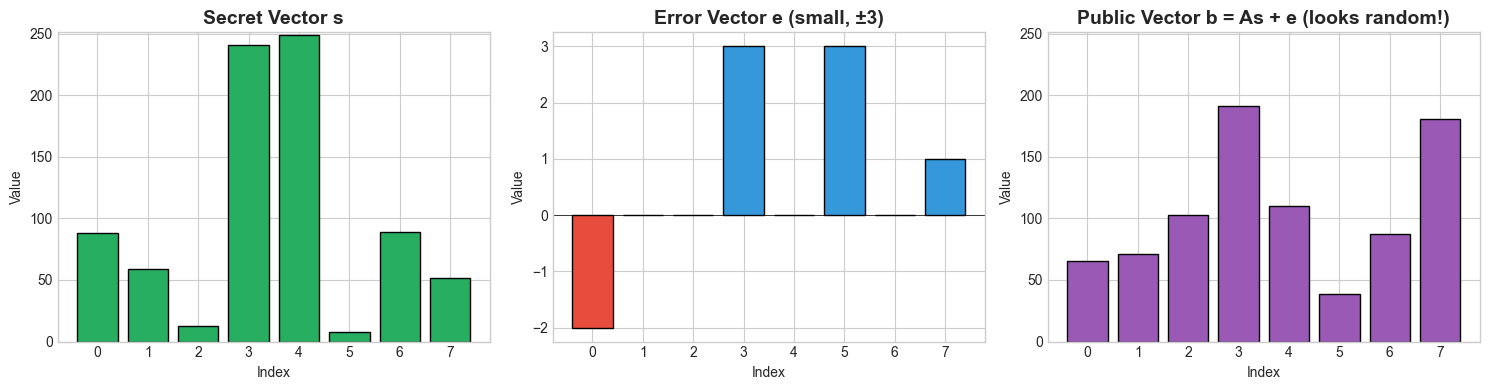


 Key Observation:
   The error e is SMALL (close to 0)
   But the public b looks COMPLETELY RANDOM!
   This is the power of LWE - small noise creates big confusion.


In [2]:
class SimpleLWE:
    """
    Simplified LWE demonstration for educational purposes.
    
    [!] NOT CRYPTOGRAPHICALLY SECURE - For learning only!
    
    This demonstrates the core principle: adding small noise
    transforms easy linear algebra into a hard problem.
    """
    
    def __init__(self, n: int = 8, m: int = 8, q: int = 251, error_bound: int = 3):
        """
        Initialize LWE parameters.
        
        Args:
            n: Number of rows in A (samples)
            m: Dimension of secret vector s
            q: Modulus (prime)
            error_bound: Maximum absolute value of error entries
        
        Real Kyber uses:
            n = 256 (polynomial degree)
            k = 2, 3, or 4 (module rank for different security levels)
            q = 3329 (a specific prime)
        """
        self.n = n
        self.m = m
        self.q = q
        self.error_bound = error_bound
        
        print("="*60)
        print("LWE PARAMETER SETUP")
        print("="*60)
        print(f"\nParameters:")
        print(f"  Matrix A: {n} × {m}")
        print(f"  Modulus q: {q}")
        print(f"  Error bound: ±{error_bound}")
        print(f"\nLWE Equation: b = A·s + e (mod {q})")
    
    def generate_keypair(self) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
        """
        Generate LWE public/private key pair.
        
        Returns:
            public_key: (A, b) where b = A·s + e
            private_key: s (the secret vector)
        """
        print("\n" + "-"*60)
        print("KEY GENERATION")
        print("-"*60)
        
        # Step 1: Generate random public matrix A
        A = np.random.randint(0, self.q, size=(self.n, self.m))
        print(f"\n[1] Generated random matrix A ({self.n}×{self.m}):")
        print(f"    A = \n{A}")
        
        # Step 2: Generate secret vector s
        s = np.random.randint(0, self.q, size=self.m)
        print(f"\n[2] Generated SECRET vector s:")
        print(f"    s = {s}")
        print(f"    (This is what we're trying to protect!)")
        
        # Step 3: Generate small error vector e
        e = np.random.randint(-self.error_bound, self.error_bound + 1, size=self.n)
        print(f"\n[3] Generated SMALL error vector e:")
        print(f"    e = {e}")
        print(f"    (Notice: entries are small, between -{self.error_bound} and +{self.error_bound})")
        
        # Step 4: Compute b = A·s + e (mod q)
        As = A @ s  # Matrix-vector multiplication
        b = (As + e) % self.q
        
        print(f"\n[4] Computing b = A·s + e (mod {self.q}):")
        print(f"    A·s = {As % self.q}")
        print(f"    e   = {e}")
        print(f"    b   = {b}")
        
        print(f"\n[OK] Key generation complete!")
        print(f"   Public key:  (A, b)")
        print(f"   Private key: s")
        
        return (A, b), s, e  # Also return e for demonstration
    
    def visualize_error_impact(self, A: np.ndarray, s: np.ndarray, 
                                b: np.ndarray, e: np.ndarray):
        """
        Visualize how the error vector obscures the true solution.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Plot 1: The secret s
        axes[0].bar(range(len(s)), s, color='#27ae60', edgecolor='black')
        axes[0].set_title('Secret Vector s', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Index')
        axes[0].set_ylabel('Value')
        axes[0].set_ylim(0, self.q)
        
        # Plot 2: The error e (small!)
        colors = ['#e74c3c' if x < 0 else '#3498db' for x in e]
        axes[1].bar(range(len(e)), e, color=colors, edgecolor='black')
        axes[1].set_title(f'Error Vector e (small, ±{self.error_bound})', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Index')
        axes[1].set_ylabel('Value')
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        # Plot 3: b looks random!
        axes[2].bar(range(len(b)), b, color='#9b59b6', edgecolor='black')
        axes[2].set_title('Public Vector b = As + e (looks random!)', 
                         fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Index')
        axes[2].set_ylabel('Value')
        axes[2].set_ylim(0, self.q)
        
        plt.tight_layout()
        plt.show()
        
        print("\n Key Observation:")
        print("   The error e is SMALL (close to 0)")
        print("   But the public b looks COMPLETELY RANDOM!")
        print("   This is the power of LWE - small noise creates big confusion.")


# =============================================================================
# DEMONSTRATE LWE KEY GENERATION
# =============================================================================

# Create LWE instance
#  INTERACTIVE: Try changing n, m, q, error_bound!
lwe = SimpleLWE(n=8, m=8, q=251, error_bound=3)

# Generate keys
(A, b), s, e = lwe.generate_keypair()

# Visualize
lwe.visualize_error_impact(A, s, b, e)

### 3.2 The Attack Simulation: Why Noise Protects the Secret

Now let's see what happens when an attacker tries to recover the secret $\mathbf{s}$.

**Attacker's view:** They know $(\mathbf{A}, \mathbf{b})$ but NOT $\mathbf{e}$.

**Naive attack:** Assume $\mathbf{e} = 0$ and solve $\mathbf{A}\mathbf{s} = \mathbf{b}$.

Let's see why this fails!


[OPEN] ATTACK SIMULATION: Solving Without Error Knowledge

  Attacker's Goal: Recover secret s from (A, b)

 Attacker's Approach:
   1. Assume error e ≈ 0 (wrong assumption!)
   2. Solve the system: A·s = b
   3. Use least-squares solution

------------------------------------------------------------
COMPARISON: True Secret vs Attacker's Guess
------------------------------------------------------------

Index    True s          Recovered s     Match?    
--------------------------------------------------
0        88              1               [X]         
1        59              0               [X]         
2        13              0               [X]         
3        241             0               [X]         
4        249             0               [X]         
5        8               0               [X]         
6        89              0               [X]         
7        52              250             [X]         

 RESULT: Attacker recovered 0/8 entries (0.0%)

[OK] LW

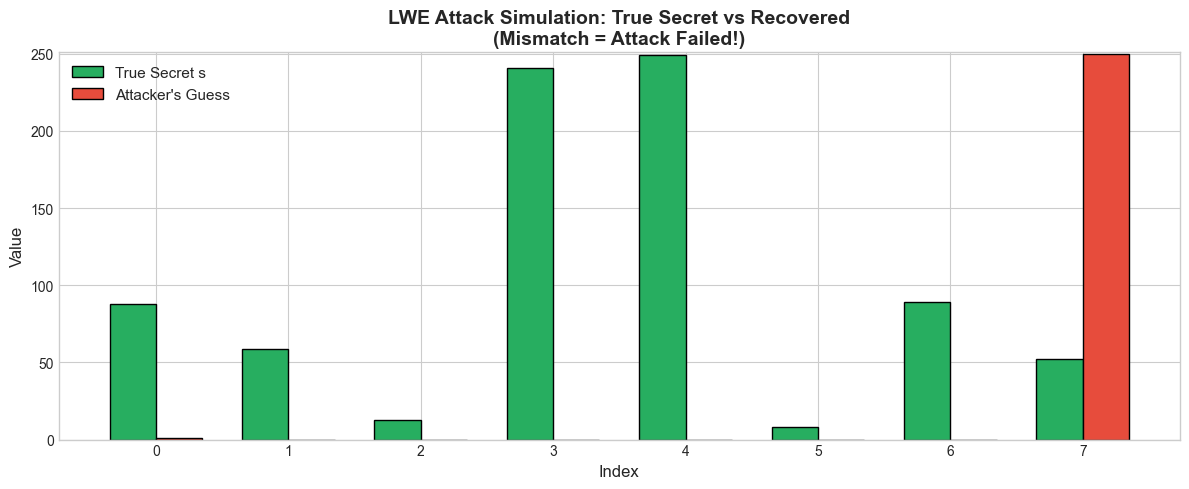

In [3]:
def attack_without_error_knowledge(A: np.ndarray, b: np.ndarray, 
                                    true_s: np.ndarray, q: int):
    """
    Simulate an attacker trying to solve LWE without knowing the error.
    
    This demonstrates that ignoring the error leads to WRONG answers.
    """
    print("\n" + "="*60)
    print("[OPEN] ATTACK SIMULATION: Solving Without Error Knowledge")
    print("="*60)
    
    print("\n  Attacker's Goal: Recover secret s from (A, b)")
    print("\n Attacker's Approach:")
    print("   1. Assume error e ≈ 0 (wrong assumption!)")
    print("   2. Solve the system: A·s = b")
    print("   3. Use least-squares solution")
    
    # Attacker tries to solve A·s = b using least squares
    # (This is the best they can do without knowing e)
    try:
        recovered_s, residuals, rank, singular = np.linalg.lstsq(A, b, rcond=None)
        recovered_s_rounded = np.round(recovered_s) % q
    except:
        recovered_s_rounded = np.linalg.solve(A, b) % q
    
    print("\n" + "-"*60)
    print("COMPARISON: True Secret vs Attacker's Guess")
    print("-"*60)
    
    print(f"\n{'Index':<8} {'True s':<15} {'Recovered s':<15} {'Match?':<10}")
    print("-" * 50)
    
    matches = 0
    for i in range(len(true_s)):
        true_val = int(true_s[i])
        recovered_val = int(recovered_s_rounded[i]) % q
        match = "[OK]" if true_val == recovered_val else "[X]"
        if true_val == recovered_val:
            matches += 1
        print(f"{i:<8} {true_val:<15} {recovered_val:<15} {match:<10}")
    
    accuracy = matches / len(true_s) * 100
    
    print("\n" + "="*60)
    print(f" RESULT: Attacker recovered {matches}/{len(true_s)} entries ({accuracy:.1f}%)")
    print("="*60)
    
    if accuracy < 100:
        print("\n[OK] LWE PROTECTION WORKED!")
        print("   The attacker FAILED to recover the secret.")
        print("   The small error 'e' has protected our secret 's'.")
    else:
        print("\n[!]  In this rare case, the attacker got lucky.")
        print("   Try running again with different random values.")
    
    # Visualize the comparison
    fig, ax = plt.subplots(figsize=(12, 5))
    
    x = np.arange(len(true_s))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, true_s, width, label='True Secret s', 
                   color='#27ae60', edgecolor='black')
    bars2 = ax.bar(x + width/2, recovered_s_rounded, width, label="Attacker's Guess", 
                   color='#e74c3c', edgecolor='black')
    
    ax.set_xlabel('Index', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title('LWE Attack Simulation: True Secret vs Recovered\n' +
                 '(Mismatch = Attack Failed!)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.legend(fontsize=11)
    ax.set_ylim(0, q)
    
    plt.tight_layout()
    plt.show()
    
    return accuracy


# Run the attack simulation
accuracy = attack_without_error_knowledge(A, b, s, lwe.q)

### 3.3 What If There Was No Error?

Let's prove that WITHOUT the error $\mathbf{e}$, the secret is trivially recoverable.

In [4]:
def solve_without_error(A: np.ndarray, s: np.ndarray, q: int):
    """
    Demonstrate that without error, the system is trivially solvable.
    """
    print("\n" + "="*60)
    print("🔍 CONTROL EXPERIMENT: Solving WITHOUT Error")
    print("="*60)
    
    # Compute b without error: b = A·s (no e!)
    b_no_error = (A @ s) % q
    
    print("\n Setup:")
    print("   b = A·s (NO error added)")
    print("\n[OPEN] Solving A·s = b using linear algebra...")
    
    # Solve
    try:
        recovered_s, _, _, _ = np.linalg.lstsq(A, b_no_error, rcond=None)
        recovered_s_rounded = np.round(recovered_s).astype(int) % q
    except:
        recovered_s_rounded = np.round(np.linalg.solve(A, b_no_error)).astype(int) % q
    
    # Check accuracy
    matches = np.sum(s == recovered_s_rounded)
    
    print(f"\n{'True s:':<15} {s}")
    print(f"{'Recovered:':<15} {recovered_s_rounded}")
    print(f"\n Match: {matches}/{len(s)} ({100*matches/len(s):.1f}%)")
    
    if matches == len(s):
        print("\n SECRET COMPLETELY RECOVERED!")
        print("   Without error, linear algebra trivially breaks the system.")
    else:
        print("\n[!]  Minor numerical error, but essentially broken.")
    
    print("\n" + "="*60)
    print("KEY INSIGHT")
    print("="*60)
    print("""
    ┌────────────────────────────────────────────────────────────┐
    │                                                            │
    │   b = A·s         →  EASY to solve (Gaussian elimination)  │
    │                                                            │
    │   b = A·s + e     →  HARD to solve (LWE problem)           │
    │                                                            │
    │   The small error e is the ENTIRE source of security!      │
    │                                                            │
    └────────────────────────────────────────────────────────────┘
    """)


# Run the control experiment
solve_without_error(A, s, lwe.q)


🔍 CONTROL EXPERIMENT: Solving WITHOUT Error

 Setup:
   b = A·s (NO error added)

[OPEN] Solving A·s = b using linear algebra...

True s:         [ 88  59  13 241 249   8  89  52]
Recovered:      [  1   0   0   0   0   0   0 250]

 Match: 0/8 (0.0%)

[!]  Minor numerical error, but essentially broken.

KEY INSIGHT

    ┌────────────────────────────────────────────────────────────┐
    │                                                            │
    │   b = A·s         →  EASY to solve (Gaussian elimination)  │
    │                                                            │
    │   b = A·s + e     →  HARD to solve (LWE problem)           │
    │                                                            │
    │   The small error e is the ENTIRE source of security!      │
    │                                                            │
    └────────────────────────────────────────────────────────────┘
    


---

## Part 4: From LWE to ML-KEM (Kyber)

### 4.1 The Leap to Real Cryptography

Our demonstration used basic LWE. Real ML-KEM (Kyber) adds several improvements:

| Feature | Our Demo (LWE) | ML-KEM (Kyber) |
|---------|---------------|----------------|
| Structure | Unstructured matrices | **Module polynomial rings** |
| Matrix A | Random $n \times m$ | Structured (NTT-friendly) |
| Key size | Large | **Compact** (due to structure) |
| Speed | Slow matrix operations | **Fast** (NTT transforms) |
| Security | "Plain" LWE | Module-LWE (equally hard) |

### 4.2 The Module-LWE Enhancement

Instead of working with matrices over $\mathbb{Z}_q$, Kyber works with **matrices of polynomials** over the ring:

$$R_q = \mathbb{Z}_q[X] / (X^{256} + 1)$$

This means:
- Each "element" is a polynomial of degree < 256
- Multiplication uses polynomial multiplication (mod $X^{256} + 1$)
- The **Number Theoretic Transform (NTT)** makes this fast!

### 4.3 KEM: Key Encapsulation Mechanism

ML-KEM doesn't directly encrypt messages. Instead, it **encapsulates shared secrets**:

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    ML-KEM KEY ENCAPSULATION                              │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│   ALICE (Receiver)                      BOB (Sender)                     │
│                                                                          │
│   1. KeyGen():                                                           │
│      (pk, sk) ← ML-KEM.KeyGen()                                          │
│                                                                          │
│   2. Send pk to Bob:                                                     │
│      ─────────────────────────────► pk                                   │
│                                                                          │
│                                     3. Encapsulate():                    │
│                                        (K, ct) ← ML-KEM.Encaps(pk)       │
│                                        K = shared secret                 │
│                                        ct = ciphertext                   │
│   4. Receive ciphertext:                                                 │
│      ct ◄─────────────────────────                                       │
│                                                                          │
│   5. Decapsulate():                                                      │
│      K ← ML-KEM.Decaps(sk, ct)                                           │
│                                                                          │
│   ═══════════════════════════════════════════════════════════════════    │
│   Both parties now share secret K, which can be used for AES!           │
│   ═══════════════════════════════════════════════════════════════════    │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

In [5]:
# Conceptual demonstration of KEM structure

print("="*60)
print("ML-KEM (KYBER) PARAMETER SETS")
print("="*60)

kem_params = {
    'ML-KEM-512': {
        'security': '128-bit (NIST Level 1)',
        'pk_size': 800,
        'sk_size': 1632,
        'ct_size': 768,
        'shared_secret': 32
    },
    'ML-KEM-768': {
        'security': '192-bit (NIST Level 3)',
        'pk_size': 1184,
        'sk_size': 2400,
        'ct_size': 1088,
        'shared_secret': 32
    },
    'ML-KEM-1024': {
        'security': '256-bit (NIST Level 5)',
        'pk_size': 1568,
        'sk_size': 3168,
        'ct_size': 1568,
        'shared_secret': 32
    }
}

print(f"\n{'Parameter Set':<15} {'Security':<25} {'PK (bytes)':<12} {'SK (bytes)':<12} {'CT (bytes)':<12}")
print("-" * 80)

for name, params in kem_params.items():
    print(f"{name:<15} {params['security']:<25} {params['pk_size']:<12} {params['sk_size']:<12} {params['ct_size']:<12}")

print("\n Notes:")
print("   • PK = Public Key size")
print("   • SK = Secret Key size")
print("   • CT = Ciphertext size")
print("   • All variants produce a 32-byte (256-bit) shared secret")
print("\n   Compare to RSA-2048: PK = 256 bytes, but BROKEN by quantum!")
print("   ML-KEM is slightly larger but QUANTUM RESISTANT.")

ML-KEM (KYBER) PARAMETER SETS

Parameter Set   Security                  PK (bytes)   SK (bytes)   CT (bytes)  
--------------------------------------------------------------------------------
ML-KEM-512      128-bit (NIST Level 1)    800          1632         768         
ML-KEM-768      192-bit (NIST Level 3)    1184         2400         1088        
ML-KEM-1024     256-bit (NIST Level 5)    1568         3168         1568        

 Notes:
   • PK = Public Key size
   • SK = Secret Key size
   • CT = Ciphertext size
   • All variants produce a 32-byte (256-bit) shared secret

   Compare to RSA-2048: PK = 256 bytes, but BROKEN by quantum!
   ML-KEM is slightly larger but QUANTUM RESISTANT.


---

## Part 5: ML-DSA (Dilithium) for Digital Signatures

### 5.1 Overview

While ML-KEM handles key exchange, **ML-DSA** provides digital signatures:

| Feature | ML-DSA (Dilithium) |
|---------|--------------------|
| Purpose | Digital signatures (authentication, integrity) |
| Security Basis | Module-LWE + Module-SIS |
| Signature Type | Fiat-Shamir with Aborts |
| Key Feature | Deterministic, no random number generation during signing |

### 5.2 How It Works (High Level)

1. **Key Generation:** Similar to LWE - generate $(A, t = As_1 + s_2)$
2. **Signing:** 
   - Generate random "mask" vector $y$
   - Compute challenge $c$ from hash of message and $Ay$
   - Compute response $z = y + cs_1$
   - **Reject** if $z$ reveals too much about $s_1$ ("abort" step)
3. **Verify:** Check that $Az - ct$ matches the hash

The "rejection sampling" is crucial — it prevents information leakage about the secret key.

In [6]:
# ML-DSA Parameter Sets

print("="*60)
print("ML-DSA (DILITHIUM) PARAMETER SETS")
print("="*60)

dsa_params = {
    'ML-DSA-44': {
        'security': '128-bit (NIST Level 2)',
        'pk_size': 1312,
        'sk_size': 2560,
        'sig_size': 2420
    },
    'ML-DSA-65': {
        'security': '192-bit (NIST Level 3)',
        'pk_size': 1952,
        'sk_size': 4032,
        'sig_size': 3293
    },
    'ML-DSA-87': {
        'security': '256-bit (NIST Level 5)',
        'pk_size': 2592,
        'sk_size': 4896,
        'sig_size': 4595
    }
}

print(f"\n{'Parameter Set':<15} {'Security':<25} {'PK (bytes)':<12} {'SK (bytes)':<12} {'Sig (bytes)':<12}")
print("-" * 80)

for name, params in dsa_params.items():
    print(f"{name:<15} {params['security']:<25} {params['pk_size']:<12} {params['sk_size']:<12} {params['sig_size']:<12}")

print("\n Comparison to classical algorithms:")
print("   RSA-2048 signature:  256 bytes (but BROKEN by quantum!)")
print("   ECDSA-256 signature: 64 bytes (but BROKEN by quantum!)")
print("   ML-DSA signature:    2420-4595 bytes (QUANTUM SAFE!)")
print("\n   The size increase is the price of quantum resistance.")

ML-DSA (DILITHIUM) PARAMETER SETS

Parameter Set   Security                  PK (bytes)   SK (bytes)   Sig (bytes) 
--------------------------------------------------------------------------------
ML-DSA-44       128-bit (NIST Level 2)    1312         2560         2420        
ML-DSA-65       192-bit (NIST Level 3)    1952         4032         3293        
ML-DSA-87       256-bit (NIST Level 5)    2592         4896         4595        

 Comparison to classical algorithms:
   RSA-2048 signature:  256 bytes (but BROKEN by quantum!)
   ECDSA-256 signature: 64 bytes (but BROKEN by quantum!)
   ML-DSA signature:    2420-4595 bytes (QUANTUM SAFE!)

   The size increase is the price of quantum resistance.


---

## Part 6: SLH-DSA (SPHINCS+) — The Conservative Choice

### 6.1 Why Hash-Based Signatures?

**SLH-DSA** uses only hash functions — no lattice assumptions:

| Advantage | Explanation |
|-----------|-------------|
| **Minimal Assumptions** | Security relies ONLY on hash function properties |
| **Well-Understood Security** | Hash functions have decades of cryptanalysis |
| **Conservative Choice** | If lattice problems are broken, SPHINCS+ survives |

### 6.2 The Trade-off

| Metric | SLH-DSA | ML-DSA |
|--------|---------|--------|
| Signature size | 7-49 KB | 2-5 KB |
| Signing speed | Slower | Faster |
| Verification speed | Slower | Faster |
| Security assumptions | Hash only | Lattice |
| "Paranoid" choice? | [OK] Yes | Less so |

**Use SLH-DSA when:**
- You need the most conservative security
- Signature size doesn't matter
- You want protection even if lattice problems are someday broken

---

## Part 7: Project Conclusion

### 7.1 Journey Recap

Across these four notebooks, we've covered:

| Notebook | Topic | Key Takeaway |
|----------|-------|-------------|
| **01** | RSA & Classical Security | RSA security relies on factoring hardness |
| **02** | Shor's Algorithm | Quantum computers can factor in polynomial time |
| **03** | Quantum Threat Visualization | Mosca's theorem, HNDL risk, timeline uncertainties |
| **04** | Post-Quantum Standards | LWE provides quantum-resistant security |

### 7.2 The Big Picture

```
┌─────────────────────────────────────────────────────────────────────────┐
│                     THE CRYPTOGRAPHIC TRANSITION                         │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│   CLASSICAL ERA                    POST-QUANTUM ERA                      │
│   (1970s - 2030s)                  (2020s onwards)                       │
│                                                                          │
│   RSA, DH, ECDSA                   ML-KEM, ML-DSA, SLH-DSA              │
│        │                                  │                              │
│        │ Factoring is hard               │ LWE is hard                  │
│        │ Discrete log is hard            │ (even for quantum!)          │
│        │                                  │                              │
│        ▼                                  ▼                              │
│   ╔═══════════════╗              ╔═══════════════╗                       │
│   ║  BROKEN BY    ║              ║  RESISTANT TO ║                       │
│   ║  SHOR'S ALGO  ║              ║  SHOR'S ALGO  ║                       │
│   ╚═══════════════╝              ╚═══════════════╝                       │
│                                                                          │
│   Timeline: Quantum computers → 2030-2040 (speculative)                  │
│   Action required: BEGIN MIGRATION NOW                                   │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

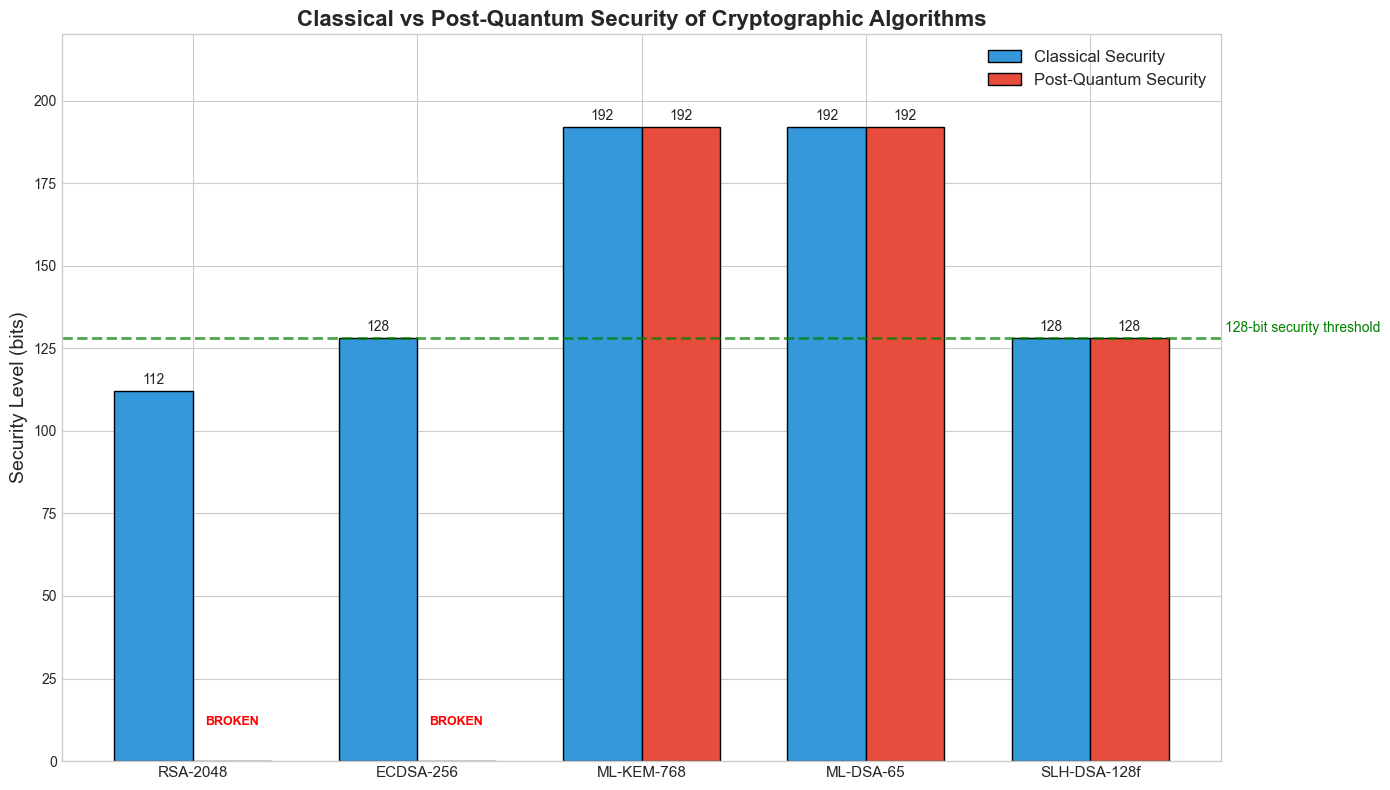


 The visualization tells the story:
   • RSA and ECDSA provide 0 bits security against quantum computers
   • Post-quantum algorithms maintain full security against both threats


In [7]:
# Final summary visualization

fig, ax = plt.subplots(figsize=(14, 8))

# Data for comparison
algorithms = ['RSA-2048', 'ECDSA-256', 'ML-KEM-768', 'ML-DSA-65', 'SLH-DSA-128f']
classical_security = [112, 128, 192, 192, 128]
quantum_security = [0, 0, 192, 192, 128]

x = np.arange(len(algorithms))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, classical_security, width, label='Classical Security', 
               color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, quantum_security, width, label='Post-Quantum Security', 
               color='#e74c3c', edgecolor='black')

# Customize
ax.set_ylabel('Security Level (bits)', fontsize=14)
ax.set_title('Classical vs Post-Quantum Security of Cryptographic Algorithms', 
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, fontsize=11)
ax.legend(fontsize=12)
ax.set_ylim(0, 220)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    if height == 0:
        ax.annotate('BROKEN',
                    xy=(bar.get_x() + bar.get_width() / 2, 10),
                    ha='center', va='bottom', fontsize=9, 
                    color='red', fontweight='bold')
    else:
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Add horizontal line for 128-bit threshold
ax.axhline(y=128, color='green', linestyle='--', alpha=0.7, linewidth=2)
ax.text(4.6, 130, '128-bit security threshold', fontsize=10, color='green')

plt.tight_layout()
plt.show()

print("\n The visualization tells the story:")
print("   • RSA and ECDSA provide 0 bits security against quantum computers")
print("   • Post-quantum algorithms maintain full security against both threats")

### 7.3 Practical Recommendations

#### For Developers

```python
# [X] DON'T: Implement your own PQC
class MyKyber:
    def encrypt(self): ...

# [OK] DO: Use established libraries
# Option 1: liboqs (Open Quantum Safe)
from oqs import KeyEncapsulation
kem = KeyEncapsulation("Kyber768")
public_key, secret_key = kem.generate_keypair()

# Option 2: pqcrypto
import pqcrypto.kem.kyber768 as kyber
pk, sk = kyber.generate_keypair()
```

#### For Organizations

1. **Inventory** your cryptographic assets
2. **Prioritize** based on data sensitivity and lifespan
3. **Pilot** hybrid (classical + PQC) deployments
4. **Train** your teams on PQC concepts
5. **Monitor** NIST guidance and updates

### 7.4 Final Thoughts

> "The best time to plant a tree was 20 years ago. The second best time is now."

The same applies to post-quantum migration. While the quantum threat timeline is uncertain, the **cost of waiting** could be catastrophic for sensitive data.

**Start your migration journey today!**

In [8]:
# Print final summary

print("="*70)
print("              PROJECT COMPLETE: QUANTUM THREATS TO CRYPTOGRAPHY")
print("="*70)
print("""
    ╔══════════════════════════════════════════════════════════════════╗
    ║                         KEY TAKEAWAYS                             ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║                                                                   ║
    ║  1. RSA/ECDSA will be BROKEN by quantum computers (Shor's algo)  ║
    ║                                                                   ║
    ║  2. AES-256 remains SAFE (Grover halves security, still strong)  ║
    ║                                                                   ║
    ║  3. ML-KEM (Kyber) replaces RSA for key exchange                 ║
    ║                                                                   ║
    ║  4. ML-DSA (Dilithium) replaces RSA/ECDSA for signatures         ║
    ║                                                                   ║
    ║  5. LWE is the mathematical foundation (hard even for quantum!)  ║
    ║                                                                   ║
    ║  6. Migration should START NOW (Mosca's theorem)                 ║
    ║                                                                   ║
    ║  7. Use liboqs/pqcrypto for production - NEVER roll your own     ║
    ║                                                                   ║
    ╚══════════════════════════════════════════════════════════════════╝
""")

print("\n Further Learning:")
print("   • NIST PQC: https://csrc.nist.gov/projects/post-quantum-cryptography")
print("   • Open Quantum Safe: https://openquantumsafe.org/")
print("   • Kyber Specification: https://pq-crystals.org/kyber/")
print("   • Dilithium Specification: https://pq-crystals.org/dilithium/")
print("\n" + "="*70)
print("                          END OF PROJECT")
print("="*70)

              PROJECT COMPLETE: QUANTUM THREATS TO CRYPTOGRAPHY

    ╔══════════════════════════════════════════════════════════════════╗
    ║                         KEY TAKEAWAYS                             ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║                                                                   ║
    ║  1. RSA/ECDSA will be BROKEN by quantum computers (Shor's algo)  ║
    ║                                                                   ║
    ║  2. AES-256 remains SAFE (Grover halves security, still strong)  ║
    ║                                                                   ║
    ║  3. ML-KEM (Kyber) replaces RSA for key exchange                 ║
    ║                                                                   ║
    ║  4. ML-DSA (Dilithium) replaces RSA/ECDSA for signatures         ║
    ║                                                                   ║
    ║  5. LWE is the mathematical foundation (hard ev

---

##  References

### Core Papers

1. Regev, O. (2005). "On lattices, learning with errors, random linear codes, and cryptography." *STOC '05*, 84-93.

2. Bos, J. et al. (2018). "CRYSTALS - Kyber: A CCA-Secure Module-Lattice-Based KEM." *IEEE Euro S&P*.

3. Ducas, L. et al. (2018). "CRYSTALS - Dilithium: A Lattice-Based Digital Signature Scheme." *TCHES*.

4. Bernstein, D.J. et al. (2015). "SPHINCS: Practical Stateless Hash-Based Signatures." *EUROCRYPT*.

### NIST Standards

- [FIPS 203: Module-Lattice-Based Key-Encapsulation Mechanism Standard](https://csrc.nist.gov/pubs/fips/203/final)
- [FIPS 204: Module-Lattice-Based Digital Signature Standard](https://csrc.nist.gov/pubs/fips/204/final)
- [FIPS 205: Stateless Hash-Based Digital Signature Standard](https://csrc.nist.gov/pubs/fips/205/final)

### Educational Resources

- [NIST Post-Quantum Cryptography FAQ](https://csrc.nist.gov/projects/post-quantum-cryptography/faqs)
- [The Lattice Club](https://thelatticeclub.com/) — Community resources
- [pq-crystals.org](https://pq-crystals.org/) — Kyber and Dilithium specifications

---

*This educational project is provided under MIT License. All implementations are for learning purposes only.*